# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#
# sys.path.insert(1, r'/content/drive/My Drive/')

In [2]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [3]:
# import sys
# sys.path.append("OM_project")

In [94]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [5]:
RETRAIN_FLAG = True

In [ ]:
RETRAIN_FLAG = False

In [6]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [7]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [8]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer)
    model.load_weights(filename)
    return model

In [ ]:
def build_and_load_model_weights(train, optimizer, filename):
    model = tf_models.build_and_compile_simple_cnn(train, optimizer)
    model.load_weights(filename)
    return model

In [9]:
def callback_for_filename(filename):
        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filename,
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
                save_weights_only=True
            )
        ]
        
        return train_callbacks

In [10]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-23 15:20:28.390541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 15:20:28.484214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 15:20:28.484602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 15:20:28.486296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
models = {}
models_states = {}
sharpnesses = {}

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [12]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10

key = ('fixed', 'sgd', 'sam')

In [14]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models[key + (batch_size,)] = model

In [15]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10


2022-02-23 15:20:35.071880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-23 15:20:36.125831: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1485/1500 [============================>.] - ETA: 0s - loss: 0.7507 - accuracy: 0.7447
Epoch 1: val_loss improved from inf to 0.24960, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 4ms/step - loss: 0.7464 - accuracy: 0.7462 - val_loss: 0.2496 - val_accuracy: 0.9340
Epoch 2/10
1495/1500 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9182
Epoch 2: val_loss improved from 0.24960 to 0.15933, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2348 - accuracy: 0.9183 - val_loss: 0.1593 - val_accuracy: 0.9588
Epoch 3/10
1493/1500 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9370
Epoch 3: val_loss improved from 0.15933 to 0.12716, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1736 - accuracy: 0.9370 -

375/375 [==============================] - 3s 8ms/step - loss: 0.2966 - accuracy: 0.9004 - val_loss: 0.2406 - val_accuracy: 0.9358
Epoch 5/10
371/375 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.9165
Epoch 5: val_loss improved from 0.24063 to 0.20481, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2499 - accuracy: 0.9166 - val_loss: 0.2048 - val_accuracy: 0.9464
Epoch 6/10
370/375 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9283
Epoch 6: val_loss improved from 0.20481 to 0.17910, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2160 - accuracy: 0.9283 - val_loss: 0.1791 - val_accuracy: 0.9528
Epoch 7/10
369/375 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9358
Epoch 7: val_loss improved from 0.17910 to 0.16051, saving model to tmp/mod

92/94 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8511
Epoch 8: val_loss improved from 0.39562 to 0.36824, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.4260 - accuracy: 0.8510 - val_loss: 0.3682 - val_accuracy: 0.8947
Epoch 9/10
94/94 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8620
Epoch 9: val_loss improved from 0.36824 to 0.34582, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3991 - accuracy: 0.8620 - val_loss: 0.3458 - val_accuracy: 0.9011
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8712
Epoch 10: val_loss improved from 0.34582 to 0.32789, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3771 - accuracy: 0.8712 - val_loss: 0

In [16]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [17]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_state_filename)

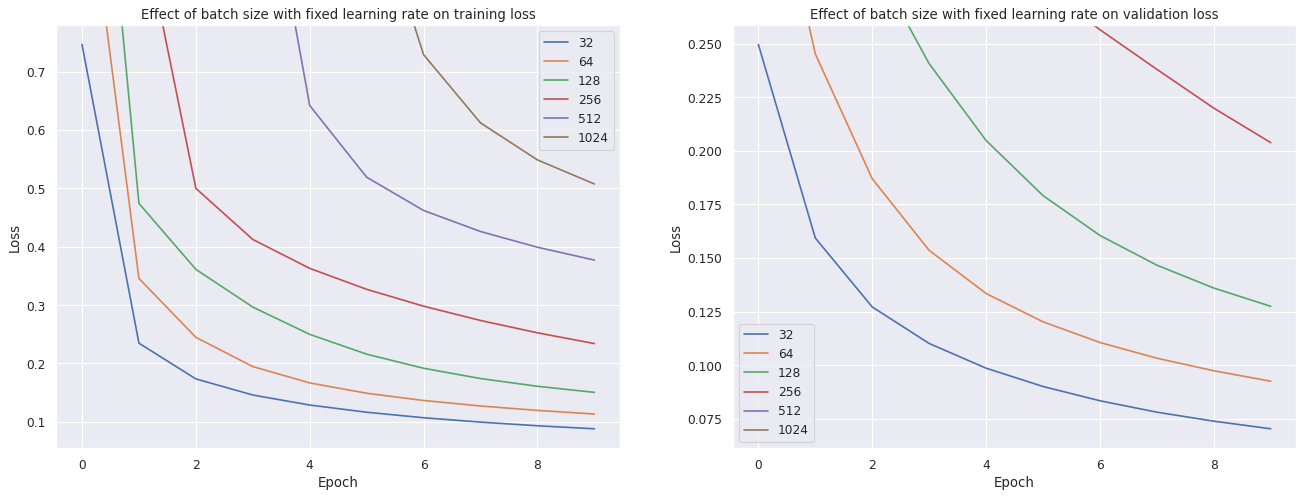

<Figure size 432x288 with 0 Axes>

In [18]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate', 'fixed_lr_diff_bs_SGD_SAM')

#### sharpness

In [19]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 15ms/step - loss: 0.0617 - accuracy: 0.9835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17284D-02    |proj g|=  1.58412D-02
47/47 [==============================] - 1s 11ms/step - loss: 4.1111 - accuracy: 0.3405

At iterate    1    f= -4.11110D+00    |proj g|=  3.16824D-02
  ys=-3.708E+02  -gs= 5.059E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 21.7996 - accuracy: 0.1335

At iterate    2    f= -2.17996D+01    |proj g|=  2.57629D-02
  ys=-1.258E+03  -gs= 2.594E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 30.2163 - accuracy: 0.0974

At iterate    3    f= -3.02163D+01    |proj g|=  2.43655D-02
  ys=-3.175E+02  -gs= 2.303E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 31.7968 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.0860 - accuracy: 0.9762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.59517D-02    |proj g|=  1.63137D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.7654 - accuracy: 0.3402

At iterate    1    f= -5.76542D+00    |proj g|=  3.26273D-02
  ys=-4.246E+02  -gs= 7.997E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 24.3855 - accuracy: 0.0976

At iterate    2    f= -2.43855D+01    |proj g|=  2.43492D-02
  ys=-1.313E+03  -gs= 2.819E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.2979 - accuracy: 0.0974

At iterate    3    f= -3.32979D+01    |proj g|=  2.33014D-02
  ys=-3.221E+02  -gs= 2.695E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 34.7585 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 34.8052 - accuracy: 0.0974

At iterate    7    f= -3.48052D+01    |proj g|=  2.27765D-02
  ys=-1.678E-01  -gs= 9.021E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 34.8880 - accuracy: 0.0974

At iterate    8    f= -3.48880D+01    |proj g|=  2.24919D-02
  ys=-1.324E+00  -gs= 3.382E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 34.8924 - accuracy: 0.0974

At iterate    9    f= -3.48924D+01    |proj g|=  2.24919D-02
12/47 [======>.......................] - ETA: 0s - loss: 35.0824 - accuracy: 0.0943


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 34.8940 - accuracy: 0.0974

At iterate   10    f= -3.48940D+01    |proj g|=  2.24919D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  64567     7 55432   2.249D-02  -3.489D+01
  F =  -34.894012451171875     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 13ms/step - loss: 0.1224 - accuracy: 0.9660
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 33.5879 - accuracy: 0.2886

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  66011     6 58780   2.903D-03  -3.359D+01
  F =  -33.587924957275391     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 7s - loss: 0.2856 - accuracy: 0.9180


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 11ms/step - loss: 0.3273 - accuracy: 0.9053
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27292D-01    |proj g|=  1.40705D-02
47/47 [==============================] - 1s 10ms/step - loss: 5.4487 - accuracy: 0.4816

At iterate    1    f= -5.44871D+00    |proj g|=  2.81411D-02
  ys=-2.332E+02  -gs= 2.425E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 27.6408 - accuracy: 0.2883

At iterate    2    f= -2.76408D+01    |proj g|=  2.29957D-02
  ys=-1.490E+03  -gs= 3.272E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 33.4719 - accuracy: 0.2881

At iterate    3    f= -3.34719D+01    |proj g|=  2.20203D-02
  ys=-1.564E+02  -gs= 2.032E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.9212 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.4346 - accuracy: 0.8750
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34560D-01    |proj g|=  1.33720D-02
47/47 [==============================] - 1s 11ms/step - loss: 6.1827 - accuracy: 0.4194

At iterate    1    f= -6.18272D+00    |proj g|=  2.67440D-02
  ys=-1.452E+02  -gs= 2.617E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 26.3793 - accuracy: 0.3667

At iterate    2    f= -2.63793D+01    |proj g|=  2.32635D-02
  ys=-9.461E+02  -gs= 5.123E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 30.0725 - accuracy: 0.3753

At iterate    3    f= -3.00725D+01    |proj g|=  2.19823D-02
  ys=-1.825E+02  -gs= 9.508E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 30.4660 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [20]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3004.6832497152504,
 ('fixed', 'sgd', 'sam', 64): 3205.3047990838536,
 ('fixed', 'sgd', 'sam', 128): 3262.596435561185,
 ('fixed', 'sgd', 'sam', 256): 2780.4372946407334,
 ('fixed', 'sgd', 'sam', 512): 2547.4219339386086,
 ('fixed', 'sgd', 'sam', 1024): 2093.451583655359}

In [21]:
models_states

{('fixed', 'sgd', 'sam'): {32: <utils.ml_utils.ModelState at 0x7fb55875a250>,
  64: <utils.ml_utils.ModelState at 0x7fb55850fdf0>,
  128: <utils.ml_utils.ModelState at 0x7fb5d00e53a0>,
  256: <utils.ml_utils.ModelState at 0x7fb55851a3a0>,
  512: <utils.ml_utils.ModelState at 0x7fb558358910>,
  1024: <utils.ml_utils.ModelState at 0x7fb5581db2b0>}}

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

In [22]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size in batch_sizes:
    # Compute mean epoch time, num epochs to converge, overall training time
    state = models_states[('fixed', 'sgd', 'sam')][batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

    print("Batch size: ", batch_size)
    print("\tMean time per epoch: ", mean_time_per_epoch)
    print("\tConverged in {} epochs".format(convergence_epoch))
    print("\tOverall training time (in seconds) until convergence: ", overall_training_time)

Batch size:  32
	Mean time per epoch:  7.539116048812867
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  69.37284731864929
Batch size:  64
	Mean time per epoch:  3.980352592468262
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  36.17679715156555
Batch size:  128
	Mean time per epoch:  2.995994448661804
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  27.094589233398438
Batch size:  256
	Mean time per epoch:  2.6202965259552
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  23.678389310836792
Batch size:  512
	Mean time per epoch:  2.3923141241073607
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.612875938415527
Batch size:  1024
	Mean time per epoch:  2.296369481086731
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  20.755096912384033


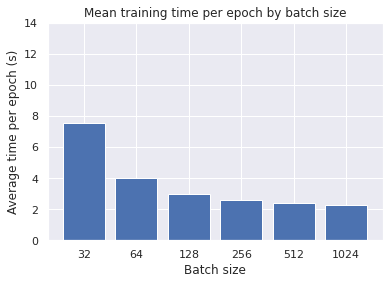

<Figure size 432x288 with 0 Axes>

In [23]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

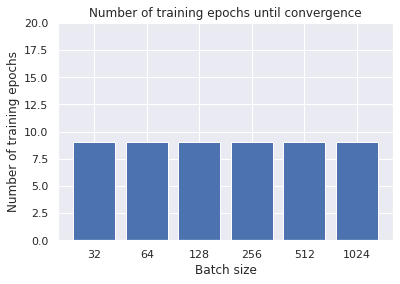

<Figure size 432x288 with 0 Axes>

In [24]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

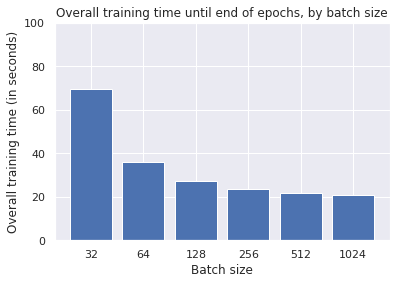

<Figure size 432x288 with 0 Axes>

In [25]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

- loss curve
- val loss curve
- final train and val loss (best) 
- sharpness of the minimizers 
- distance from initial weights

- training time
- training time per epoch 
- epochs needed to converge 
- parallelization 
- training time times sharpness

### SGD with Momentum + ASAM

In [26]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = 10

key = ('fixed', 'sgd', 'asam')

In [27]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [28]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [29]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10
1493/1500 [============================>.] - ETA: 0s - loss: 0.7353 - accuracy: 0.7511
Epoch 1: val_loss improved from inf to 0.24548, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7334 - accuracy: 0.7518 - val_loss: 0.2455 - val_accuracy: 0.9344
Epoch 2/10
1500/1500 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9189
Epoch 2: val_loss improved from 0.24548 to 0.15533, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2286 - accuracy: 0.9189 - val_loss: 0.1553 - val_accuracy: 0.9592
Epoch 3/10
1497/1500 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9384
Epoch 3: val_loss improved from 0.15533 to 0.12434, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1692 - accu

375/375 [==============================] - 3s 8ms/step - loss: 0.2774 - accuracy: 0.9065 - val_loss: 0.2259 - val_accuracy: 0.9405
Epoch 5/10
370/375 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9215
Epoch 5: val_loss improved from 0.22593 to 0.19442, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 7ms/step - loss: 0.2352 - accuracy: 0.9216 - val_loss: 0.1944 - val_accuracy: 0.9479
Epoch 6/10
370/375 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9313
Epoch 6: val_loss improved from 0.19442 to 0.17189, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 7ms/step - loss: 0.2055 - accuracy: 0.9313 - val_loss: 0.1719 - val_accuracy: 0.9527
Epoch 7/10
372/375 [============================>.] - ETA: 0s - loss: 0.1841 - accuracy: 0.9386
Epoch 7: val_loss improved from 0.17189 to 0.15535, saving model to tmp/m

94/94 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8620
Epoch 8: val_loss improved from 0.37107 to 0.34534, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.4016 - accuracy: 0.8620 - val_loss: 0.3453 - val_accuracy: 0.9033
Epoch 9/10
93/94 [============================>.] - ETA: 0s - loss: 0.3766 - accuracy: 0.8721
Epoch 9: val_loss improved from 0.34534 to 0.32536, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3766 - accuracy: 0.8720 - val_loss: 0.3254 - val_accuracy: 0.9096
Epoch 10/10
94/94 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8798
Epoch 10: val_loss improved from 0.32536 to 0.30891, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3561 - accuracy: 0.8798 - val_loss

In [30]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [31]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

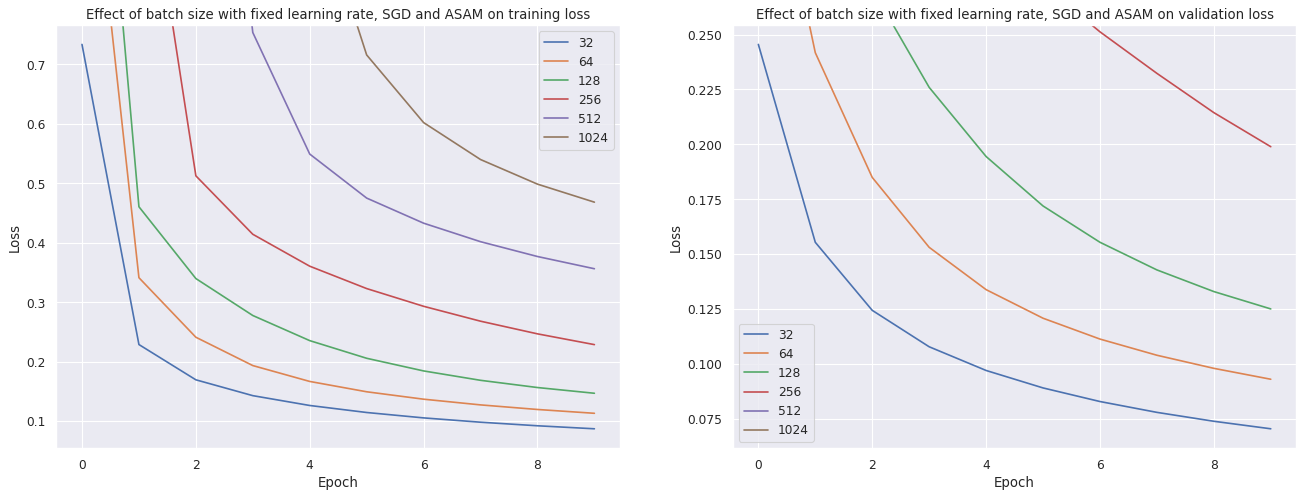

<Figure size 432x288 with 0 Axes>

In [32]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM', 'model_fixed_lr_diff_bs_sgd_asam_state')

#### sharpness

In [33]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 11ms/step - loss: 0.0615 - accuracy: 0.9832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.14574D-02    |proj g|=  1.44559D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.5150 - accuracy: 0.3578

At iterate    1    f= -3.51500D+00    |proj g|=  2.89117D-02
  ys=-3.065E+02  -gs= 4.973E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 21.9923 - accuracy: 0.1818

At iterate    2    f= -2.19923D+01    |proj g|=  2.39773D-02
  ys=-1.382E+03  -gs= 2.423E+02 BFGS update SKIPPED
47/47 [==============================] - 0s 10ms/step - loss: 28.2057 - accuracy: 0.1912

At iterate    3    f= -2.82057D+01    |proj g|=  2.34084D-02
  ys=-2.819E+02  -gs= 1.656E+02 BFGS update SKIPPED
47/47 [==============================] - 0s 10ms/step - loss: 29.6648 - acc

47/47 [==============================] - 1s 10ms/step - loss: 36.0525 - accuracy: 0.1911

At iterate   10    f= -3.60525D+01    |proj g|=  1.65934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     11  64930     9 57461   1.659D-02  -3.605D+01
  F =  -36.052497863769531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 14ms/step - loss: 0.1952 - accuracy: 0.9448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 16ms/step - loss: 0.3078 - accuracy: 0.9122
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07816D-01    |proj g|=  1.42131D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.7622 - accuracy: 0.4471

At iterate    1    f= -5.76223D+00    |proj g|=  2.84262D-02
  ys=-2.596E+02  -gs= 2.019E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 25.2292 - accuracy: 0.3637

At iterate    2    f= -2.52292D+01    |proj g|=  2.30851D-02
  ys=-1.122E+03  -gs= 3.989E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.4869 - accuracy: 0.2811

At iterate    3    f= -3.14869D+01    |proj g|=  2.14811D-02
  ys=-3.574E+02  -gs= 8.405E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 32.6612 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.3999 - accuracy: 0.8865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.99916D-01    |proj g|=  1.32137D-02
47/47 [==============================] - 0s 10ms/step - loss: 7.2957 - accuracy: 0.4237

At iterate    1    f= -7.29566D+00    |proj g|=  2.64274D-02
  ys=-2.517E+02  -gs= 2.534E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 28.8701 - accuracy: 0.3704

At iterate    2    f= -2.88701D+01    |proj g|=  2.41202D-02
  ys=-1.108E+03  -gs= 5.015E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.8877 - accuracy: 0.3774

At iterate    3    f= -3.18877D+01    |proj g|=  2.16937D-02
  ys=-1.044E+02  -gs= 9.586E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 32.5905 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      6      7  67092     5 57901   2.238D-03  -3.261D+01
  F =  -32.614219665527344     

ABNORMAL_TERMINATION_IN_LNSRCH                              


#### Runtime

In [34]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  6.96040666103363
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  62.36198401451111
Batch size:  64
	Mean time per epoch:  4.296233463287353
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  39.066126108169556
Batch size:  128
	Mean time per epoch:  2.9195334672927857
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  26.478610277175903
Batch size:  256
	Mean time per epoch:  2.650056982040405
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  23.802733659744263
Batch size:  512
	Mean time per epoch:  2.3507358551025392
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.136536598205566
Batch size:  1024
	Mean time per epoch:  2.1619382381439207
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  19.544416904449463


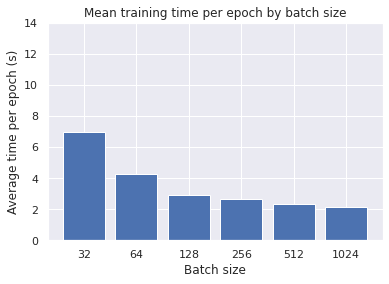

<Figure size 432x288 with 0 Axes>

In [35]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

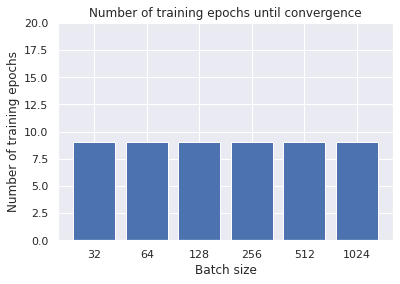

<Figure size 432x288 with 0 Axes>

In [36]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

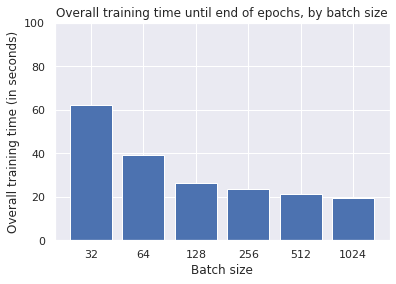

<Figure size 432x288 with 0 Axes>

In [37]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

### ADAM + SAM 

In [67]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10

key = ('fixed', 'adam', 'sam')

In [68]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        models[key + (batch_size,)] = model

In [70]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = tf_models.build_simple_cnn_sam(train, optimizer)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10
1497/1500 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9322
Epoch 1: val_loss improved from inf to 0.06231, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1881 - accuracy: 0.9323 - val_loss: 0.0623 - val_accuracy: 0.9828
Epoch 2/10
1497/1500 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9752
Epoch 2: val_loss improved from 0.06231 to 0.04766, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0646 - accuracy: 0.9752 - val_loss: 0.0477 - val_accuracy: 0.9869
Epoch 3/10
1497/1500 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9823
Epoch 3: val_loss improved from 0.04766 to 0.04203, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0460 - accuracy: 0.9823

Epoch 7/10
373/375 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9888
Epoch 7: val_loss improved from 0.04413 to 0.04194, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.0317 - accuracy: 0.9888 - val_loss: 0.0419 - val_accuracy: 0.9877
Epoch 8/10
375/375 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9903
Epoch 8: val_loss improved from 0.04194 to 0.04134, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.0272 - accuracy: 0.9903 - val_loss: 0.0413 - val_accuracy: 0.9874
Epoch 9/10
372/375 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9913
Epoch 9: val_loss improved from 0.04134 to 0.04047, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.0234 - accuracy: 0.9913 - va

Epoch 1/10
46/47 [============================>.] - ETA: 0s - loss: 1.0487 - accuracy: 0.7006
Epoch 1: val_loss improved from inf to 0.35690, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 3s 58ms/step - loss: 1.0365 - accuracy: 0.7036 - val_loss: 0.3569 - val_accuracy: 0.8947
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.9031
Epoch 2: val_loss improved from 0.35690 to 0.22189, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3003 - accuracy: 0.9031 - val_loss: 0.2219 - val_accuracy: 0.9374
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9355
Epoch 3: val_loss improved from 0.22189 to 0.16435, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2030 - accuracy: 0.9355 - val_loss: 0.

In [71]:
state_filename = 'model_fixed_lr_diff_bs_adam_sam_state'

In [72]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

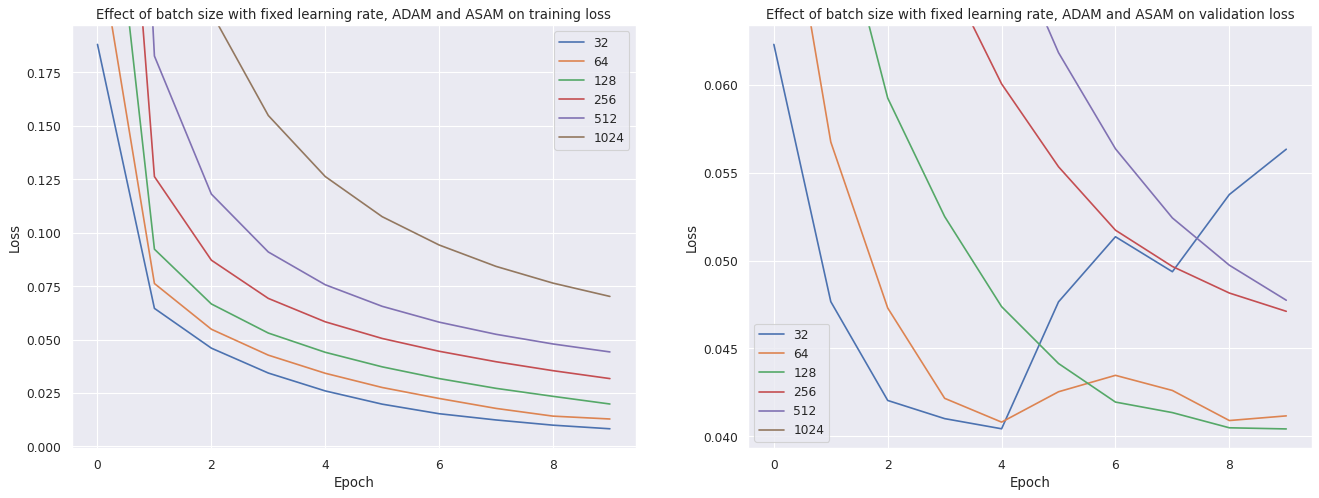

<Figure size 432x288 with 0 Axes>

In [73]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM', state_filename)

#### sharpness

In [74]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 15ms/step - loss: 0.0093 - accuracy: 0.9968
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.25849D-03    |proj g|=  1.76772D-02
47/47 [==============================] - 1s 10ms/step - loss: 0.8583 - accuracy: 0.8373

At iterate    1    f= -8.58278D-01    |proj g|=  2.91312D-02
  ys=-1.239E+02  -gs= 2.475E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.9007 - accuracy: 0.6913

At iterate    2    f= -1.90074D+00    |proj g|=  3.03499D-02
  ys=-4.942E+01  -gs= 2.850E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 2.1091 - accuracy: 0.6570

At iterate    3    f= -2.10913D+00    |proj g|=  2.98354D-02
  ys=-4.158E+00  -gs= 7.551E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 2.1478 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 2.1656 - accuracy: 0.6457

At iterate    7    f= -2.16558D+00    |proj g|=  2.61866D-02
13/47 [=======>......................] - ETA: 0s - loss: 2.1790 - accuracy: 0.6460


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 2.1685 - accuracy: 0.6454

At iterate    8    f= -2.16848D+00    |proj g|=  2.61866D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.1701 - accuracy: 0.6453

At iterate    9    f= -2.17014D+00    |proj g|=  2.59794D-02
13/47 [=======>......................] - ETA: 0s - loss: 2.1777 - accuracy: 0.6451


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 2.1671 - accuracy: 0.6449

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     14  49208     4 46886   2.598D-02  -2.170D+00
  F =  -2.1701366901397705     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 7s - loss: 0.0114 - accuracy: 0.9951


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 14ms/step - loss: 0.0105 - accuracy: 0.9966
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04627D-02    |proj g|=  1.69309D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.6310 - accuracy: 0.6696

At iterate    1    f= -1.63096D+00    |proj g|=  3.00784D-02
  ys=-2.236E+02  -gs= 2.589E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 4.4554 - accuracy: 0.3702

At iterate    2    f= -4.45535D+00    |proj g|=  2.98564D-02
  ys=-1.795E+02  -gs= 6.200E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 4.8482 - accuracy: 0.3319

At iterate    3    f= -4.84822D+00    |proj g|=  2.94877D-02
  ys=-4.774E+00  -gs= 1.551E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 4.8657 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 0s 10ms/step - loss: 4.9045 - accuracy: 0.3286

At iterate    9    f= -4.90448D+00    |proj g|=  2.88783D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.9069 - accuracy: 0.3285

At iterate   10    f= -4.90692D+00    |proj g|=  2.88621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  50524     3 48029   2.886D-02  -4.907D+00
  F =  -4.9069213867187500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 13ms/step - loss: 0.0144 - accuracy: 0.9959
RUNNING THE L-BFGS-B CODE

        


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 10ms/step - loss: 24.2537 - accuracy: 0.0974

At iterate   10    f= -2.42537D+01    |proj g|=  3.57905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  62280     8 54512   3.579D-03  -2.425D+01
  F =  -24.253744125366211     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 14ms/step - loss: 0.0339 - accuracy: 0.9906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 24.7547 - accuracy: 0.2911

At iterate    8    f= -2.47547D+01    |proj g|=  2.01660D-02
  ys=-2.335E-01  -gs= 1.113E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 24.7720 - accuracy: 0.2911

At iterate    9    f= -2.47720D+01    |proj g|=  2.25406D-02
  ys=-4.562E-02  -gs= 1.221E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 24.9165 - accuracy: 0.2914

At iterate   10    f= -2.49165D+01    |proj g|=  2.25406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  57

#### Runtime

In [75]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  6.435037064552307
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  25.67646312713623
Batch size:  64
	Mean time per epoch:  3.970466446876526
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  15.362546920776367
Batch size:  128
	Mean time per epoch:  3.14706711769104
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  28.4251971244812
Batch size:  256
	Mean time per epoch:  2.649314117431641
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  24.085453033447266
Batch size:  512
	Mean time per epoch:  2.2387652158737184
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  20.25190019607544
Batch size:  1024
	Mean time per epoch:  2.194883608818054
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  19.78974986076355


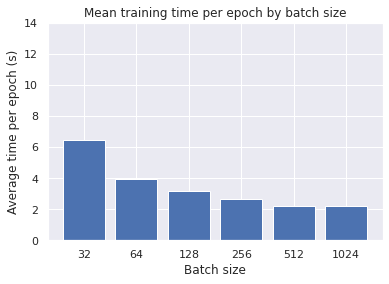

<Figure size 432x288 with 0 Axes>

In [76]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

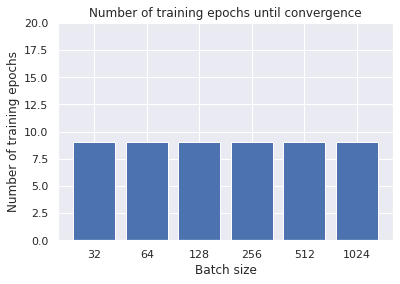

<Figure size 432x288 with 0 Axes>

In [77]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

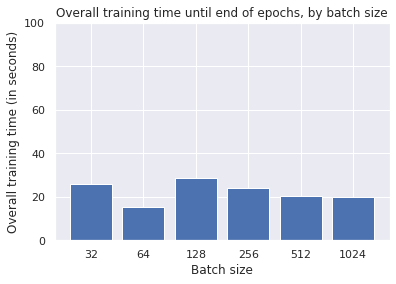

<Figure size 432x288 with 0 Axes>

In [78]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

### ADAM + ASAM

In [79]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10

key = ('fixed', 'adam', 'asam')

In [80]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        models[key + (batch_size,)] = model

In [81]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10
1496/1500 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9225
Epoch 1: val_loss improved from inf to 0.06640, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2097 - accuracy: 0.9226 - val_loss: 0.0664 - val_accuracy: 0.9822
Epoch 2/10
1500/1500 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9648
Epoch 2: val_loss improved from 0.06640 to 0.04881, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0870 - accuracy: 0.9648 - val_loss: 0.0488 - val_accuracy: 0.9864
Epoch 3/10
1499/1500 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9700
Epoch 3: val_loss improved from 0.04881 to 0.04182, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0695 - accuracy: 0.9

374/375 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9784
Epoch 5: val_loss improved from 0.05374 to 0.04725, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.0596 - accuracy: 0.9784 - val_loss: 0.0472 - val_accuracy: 0.9866
Epoch 6/10
375/375 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9809
Epoch 6: val_loss improved from 0.04725 to 0.04281, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.0521 - accuracy: 0.9809 - val_loss: 0.0428 - val_accuracy: 0.9877
Epoch 7/10
374/375 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9829
Epoch 7: val_loss improved from 0.04281 to 0.04011, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.0461 - accuracy: 0.9829 - val_loss: 

Epoch 9/10
92/94 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9785
Epoch 9: val_loss improved from 0.05776 to 0.05480, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0603 - accuracy: 0.9784 - val_loss: 0.0548 - val_accuracy: 0.9838
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9799
Epoch 10: val_loss improved from 0.05480 to 0.05278, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0561 - accuracy: 0.9799 - val_loss: 0.0528 - val_accuracy: 0.9849
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.7008
Epoch 1: val_loss improved from inf to 0.39148, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 3s 58ms/step - loss: 1.0813 - accuracy: 0.7008 - val_loss:

In [82]:
state_filename = 'model_fixed_lr_diff_bs_adam_asam_state'

In [83]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

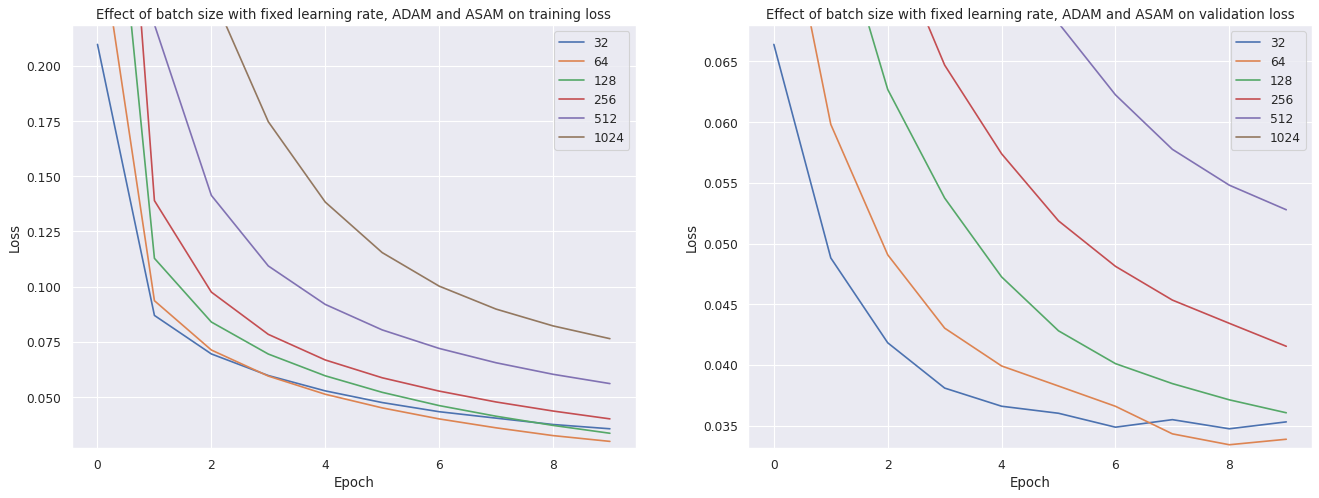

<Figure size 432x288 with 0 Axes>

In [84]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM', state_filename)

#### sharpness

In [85]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 14ms/step - loss: 0.0081 - accuracy: 0.9982
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.10997D-03    |proj g|=  1.61740D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.0420 - accuracy: 0.9865

At iterate    1    f= -4.20152D-02    |proj g|=  2.67952D-02
  ys=-3.173E+00  -gs= 4.355E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.2811 - accuracy: 0.9068

At iterate    2    f= -2.81149D-01    |proj g|=  2.95869D-02
  ys=-2.231E+01  -gs= 3.390E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.4154 - accuracy: 0.8676

At iterate    3    f= -4.15389D-01    |proj g|=  3.08302D-02
  ys=-3.384E+00  -gs= 4.825E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.4686 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 0.4639 - accuracy: 0.8519

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      6      8  39054     4 37628   3.378D-02  -4.686D-01
  F = -0.46864616870880127     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 7s - loss: 0.0123 - accuracy: 0.9971


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 15ms/step - loss: 0.0094 - accuracy: 0.9980
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.38799D-03    |proj g|=  1.65668D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.2040 - accuracy: 0.9320

At iterate    1    f= -2.03981D-01    |proj g|=  2.46709D-02
  ys=-2.635E+01  -gs= 9.323E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 1.0941 - accuracy: 0.7413

At iterate    2    f= -1.09413D+00    |proj g|=  3.31335D-02
  ys=-6.551E+01  -gs= 1.616E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.3356 - accuracy: 0.6946

At iterate    3    f= -1.33556D+00    |proj g|=  3.36276D-02
  ys=-7.129E+00  -gs= 8.426E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.4173 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 7.8204 - accuracy: 0.2123

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      7      9  59445     4 52978   2.423D-02  -7.824D+00
  F =  -7.8238182067871094     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 7s - loss: 0.0227 - accuracy: 0.9932


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 12ms/step - loss: 0.0252 - accuracy: 0.9934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.52410D-02    |proj g|=  1.45781D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.7751 - accuracy: 0.4821

At iterate    1    f= -3.77509D+00    |proj g|=  2.75149D-02
  ys=-3.700E+02  -gs= 4.740E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 13.4202 - accuracy: 0.1913

At iterate    2    f= -1.34202D+01    |proj g|=  2.91105D-02
  ys=-5.872E+02  -gs= 1.710E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 15.9449 - accuracy: 0.1459

At iterate    3    f= -1.59449D+01    |proj g|=  2.71662D-02
  ys=-1.192E+02  -gs= 6.392E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 17.6494 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 10ms/step - loss: 18.0537 - accuracy: 0.0988

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  63200     5 54882   2.420D-02  -1.808D+01
  F =  -18.076066970825195     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 8s - loss: 0.0372 - accuracy: 0.9912


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 11ms/step - loss: 0.0390 - accuracy: 0.9891
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.89715D-02    |proj g|=  1.42118D-02
47/47 [==============================] - 1s 11ms/step - loss: 6.0764 - accuracy: 0.3994

At iterate    1    f= -6.07639D+00    |proj g|=  2.84237D-02
  ys=-5.574E+02  -gs= 4.326E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 20.1806 - accuracy: 0.2679

At iterate    2    f= -2.01806D+01    |proj g|=  2.84237D-02
  ys=-7.669E+02  -gs= 2.947E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 25.4840 - accuracy: 0.1975

At iterate    3    f= -2.54840D+01    |proj g|=  2.74765D-02
  ys=-2.378E+02  -gs= 9.791E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 26.2374 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 26.5998 - accuracy: 0.1934

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      7      9  65110     5 56827   2.448D-02  -2.661D+01
  F =  -26.612909317016602     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


#### Runtime

In [86]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.593124008178711
	Converged in 8 epochs
	Overall training time (in seconds) until convergence:  61.436339378356934
Batch size:  64
	Mean time per epoch:  4.220664358139038
	Converged in 8 epochs
	Overall training time (in seconds) until convergence:  34.72942495346069
Batch size:  128
	Mean time per epoch:  3.0448401927948
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  27.604305028915405
Batch size:  256
	Mean time per epoch:  2.671896815299988
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  24.052659273147583
Batch size:  512
	Mean time per epoch:  2.363131308555603
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.34805154800415
Batch size:  1024
	Mean time per epoch:  2.23075385093689
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  20.178451776504517


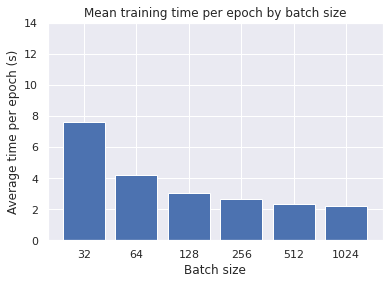

<Figure size 432x288 with 0 Axes>

In [87]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

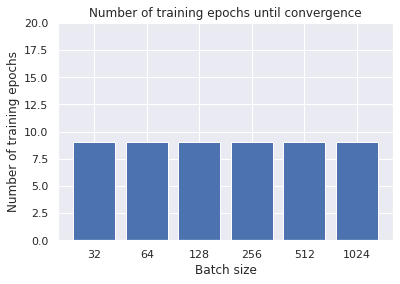

<Figure size 432x288 with 0 Axes>

In [88]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

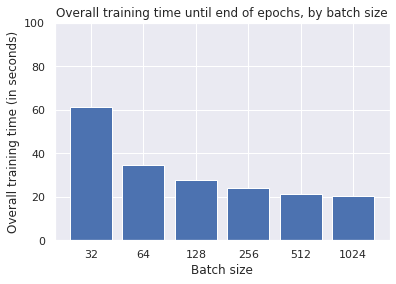

<Figure size 432x288 with 0 Axes>

In [89]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

## without sharpness aware minimization

In [90]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3004.6832497152504,
 ('fixed', 'sgd', 'sam', 64): 3205.3047990838536,
 ('fixed', 'sgd', 'sam', 128): 3262.596435561185,
 ('fixed', 'sgd', 'sam', 256): 2780.4372946407334,
 ('fixed', 'sgd', 'sam', 512): 2547.4219339386086,
 ('fixed', 'sgd', 'sam', 1024): 2093.451583655359,
 ('fixed', 'sgd', 'asam', 32): 2830.121866418174,
 ('fixed', 'sgd', 'asam', 64): 3335.878978298347,
 ('fixed', 'sgd', 'asam', 128): 3211.113582873208,
 ('fixed', 'sgd', 'asam', 256): 2788.7943896653946,
 ('fixed', 'sgd', 'asam', 512): 2473.5385935256895,
 ('fixed', 'sgd', 'asam', 1024): 2301.159635175606,
 ('increasing', 'sgd', 'sam', 32, 0.001): 1784.6237600877948,
 ('increasing', 'sgd', 'sam', 64, 0.002): 2418.1310305294387,
 ('increasing', 'sgd', 'sam', 128, 0.004): 2483.0266277208334,
 ('increasing', 'sgd', 'sam', 256, 0.008): 3435.485341318249,
 ('increasing', 'sgd', 'sam', 512, 0.016): 3299.348872531065,
 ('increasing', 'sgd', 'sam', 1024, 0.032): 468.834091695867,
 ('fixed', 'adam'

### SGD with Momemtum

In [95]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10

key = ('fixed', 'sgd', 'none')

In [96]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        models[key + (batch_size,)] = model

In [101]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_and_compile_simple_cnn(train, optimizer)
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10
1477/1500 [============================>.] - ETA: 0s - loss: 0.7740 - accuracy: 0.7514
Epoch 1: val_loss improved from inf to 0.34591, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7685 - accuracy: 0.7533 - val_loss: 0.3459 - val_accuracy: 0.9134
Epoch 2/10
1492/1500 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8937
Epoch 2: val_loss improved from 0.34591 to 0.23050, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3478 - accuracy: 0.8936 - val_loss: 0.2305 - val_accuracy: 0.9457
Epoch 3/10
1487/1500 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.9225
Epoch 3: val_loss improved from 0.23050 to 0.18961, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2549 - accu

375/375 [==============================] - 2s 5ms/step - loss: 0.4572 - accuracy: 0.8595 - val_loss: 0.3559 - val_accuracy: 0.9030
Epoch 5/10
370/375 [============================>.] - ETA: 0s - loss: 0.4072 - accuracy: 0.8757
Epoch 5: val_loss improved from 0.35587 to 0.31053, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.4074 - accuracy: 0.8758 - val_loss: 0.3105 - val_accuracy: 0.9192
Epoch 6/10
366/375 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8896
Epoch 6: val_loss improved from 0.31053 to 0.28077, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.3642 - accuracy: 0.8896 - val_loss: 0.2808 - val_accuracy: 0.9285
Epoch 7/10
373/375 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.9028
Epoch 7: val_loss improved from 0.28077 to 0.24649, saving model to tmp/m

92/94 [============================>.] - ETA: 0s - loss: 0.5471 - accuracy: 0.8283
Epoch 8: val_loss improved from 0.44315 to 0.42374, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 14ms/step - loss: 0.5470 - accuracy: 0.8284 - val_loss: 0.4237 - val_accuracy: 0.8862
Epoch 9/10
94/94 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.8341
Epoch 9: val_loss improved from 0.42374 to 0.41330, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 14ms/step - loss: 0.5243 - accuracy: 0.8341 - val_loss: 0.4133 - val_accuracy: 0.8856
Epoch 10/10
91/94 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8421
Epoch 10: val_loss improved from 0.41330 to 0.39953, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 14ms/step - loss: 0.5051 - accuracy: 0.8422 - val_loss

In [102]:
state_filename = 'model_fixed_lr_diff_bs_noSAM_state'

In [103]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

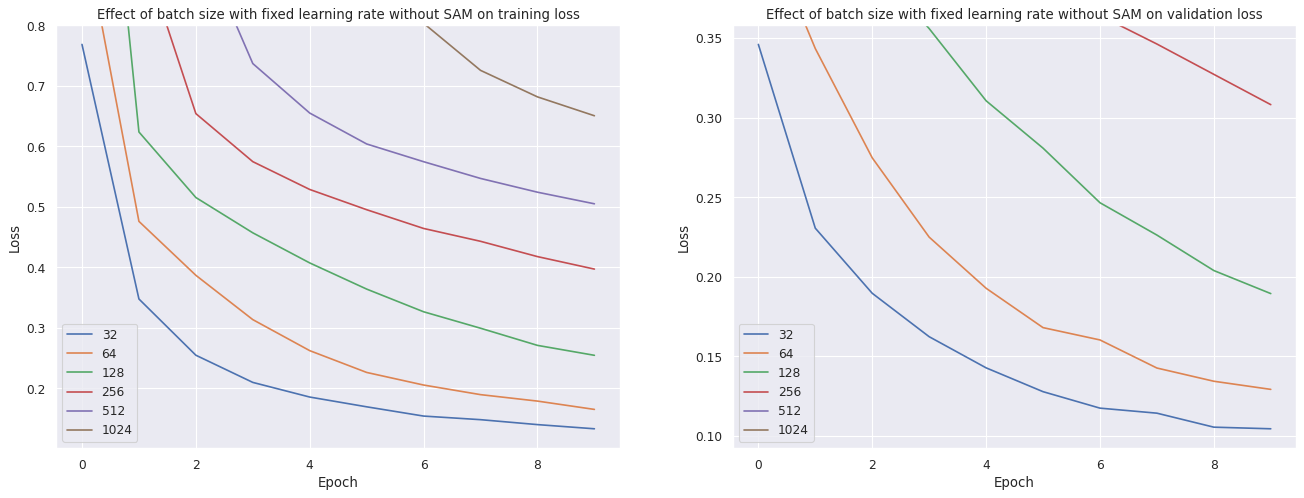

<Figure size 432x288 with 0 Axes>

In [104]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM', 'fixed_lr_diff_bs_SGD_noSAM')

#### sharpness

In [106]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 11ms/step - loss: 0.0969 - accuracy: 0.9734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.68525D-02    |proj g|=  1.49410D-02
47/47 [==============================] - 1s 10ms/step - loss: 2.3749 - accuracy: 0.4216

At iterate    1    f= -2.37485D+00    |proj g|=  2.98821D-02
  ys=-1.249E+02  -gs= 1.312E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.2220 - accuracy: 0.2798

At iterate    2    f= -9.22198D+00    |proj g|=  2.62889D-02
  ys=-5.930E+02  -gs= 9.870E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 13.7195 - accuracy: 0.2027

At iterate    3    f= -1.37195D+01    |proj g|=  2.62889D-02
  ys=-2.774E+02  -gs= 9.327E+01 BFGS update SKIPPED
47/47 [==============================] - 0s 10ms/step - loss: 16.1727 - accu

47/47 [==============================] - 1s 12ms/step - loss: 29.5572 - accuracy: 0.1906

At iterate   10    f= -2.95572D+01    |proj g|=  2.16922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     11  74066     9 57770   2.169D-02  -2.956D+01
  F =  -29.557151794433594     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 12ms/step - loss: 0.3054 - accuracy: 0.9201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 25.8311 - accuracy: 0.2638

At iterate    2    f= -2.58311D+01    |proj g|=  2.31750D-02
  ys=-1.087E+03  -gs= 4.628E+02 BFGS update SKIPPED
47/47 [==============================] - 0s 10ms/step - loss: 30.8911 - accuracy: 0.2766

At iterate    3    f= -3.08911D+01    |proj g|=  2.17665D-02
  ys=-2.935E+02  -gs= 1.185E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 31.3891 - accuracy: 0.2766

At iterate    4    f= -3.13891D+01    |proj g|=  1.53575D-02
  ys=-2.040E+01  -gs= 1.249E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.4154 - accuracy: 0.2765

At iterate    5    f= -3.14154D+01    |proj g|=  7.89681D-03
  ys=-3.322E-01  -gs= 1.096E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 31.4154 - accuracy: 0.2765

At iterate    6    f= -3.14154D+01    |proj g|=  9.71854D-04
  ys=-1.515E-04  -gs= 1.993E-03 BFGS 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [112]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3004.6832497152504,
 ('fixed', 'sgd', 'sam', 64): 3205.3047990838536,
 ('fixed', 'sgd', 'sam', 128): 3262.596435561185,
 ('fixed', 'sgd', 'sam', 256): 2780.4372946407334,
 ('fixed', 'sgd', 'sam', 512): 2547.4219339386086,
 ('fixed', 'sgd', 'sam', 1024): 2093.451583655359,
 ('fixed', 'sgd', 'asam', 32): 2830.121866418174,
 ('fixed', 'sgd', 'asam', 64): 3335.878978298347,
 ('fixed', 'sgd', 'asam', 128): 3211.113582873208,
 ('fixed', 'sgd', 'asam', 256): 2788.7943896653946,
 ('fixed', 'sgd', 'asam', 512): 2473.5385935256895,
 ('fixed', 'sgd', 'asam', 1024): 2301.159635175606,
 ('increasing', 'sgd', 'sam', 32, 0.001): 1784.6237600877948,
 ('increasing', 'sgd', 'sam', 64, 0.002): 2418.1310305294387,
 ('increasing', 'sgd', 'sam', 128, 0.004): 2483.0266277208334,
 ('increasing', 'sgd', 'sam', 256, 0.008): 3435.485341318249,
 ('increasing', 'sgd', 'sam', 512, 0.016): 3299.348872531065,
 ('increasing', 'sgd', 'sam', 1024, 0.032): 468.834091695867,
 ('fixed', 'adam'

#### Runtime

In [107]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  4.741232681274414
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  43.071388959884644
Batch size:  64
	Mean time per epoch:  2.868933606147766
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  25.949697256088257
Batch size:  128
	Mean time per epoch:  2.0325955152511597
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  18.265764236450195
Batch size:  256
	Mean time per epoch:  1.69066379070282
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  15.4133882522583
Batch size:  512
	Mean time per epoch:  1.4401086807250976
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  13.123469114303589
Batch size:  1024
	Mean time per epoch:  1.3310756444931031
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  12.107265949249268


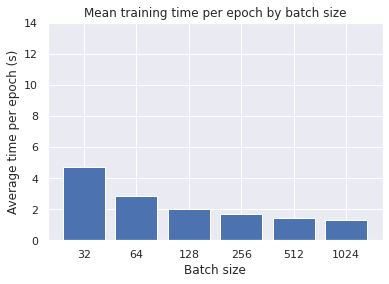

<Figure size 432x288 with 0 Axes>

In [108]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

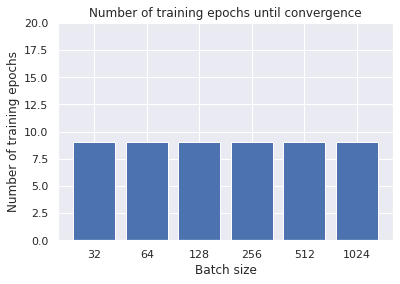

<Figure size 432x288 with 0 Axes>

In [110]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

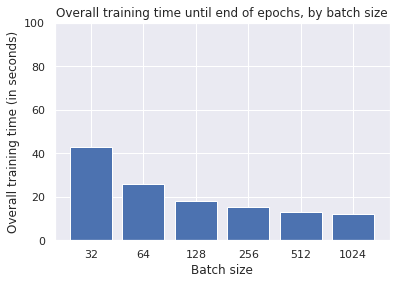

<Figure size 432x288 with 0 Axes>

In [111]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

### ADAM

In [113]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10

key = ('fixed', 'adam', 'none')

In [114]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        models[key + (batch_size,)] = model

In [115]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = tf_models.build_and_compile_simple_cnn(train, optimizer)
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size,)] = model

Epoch 1/10
1480/1500 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.9090
Epoch 1: val_loss improved from inf to 0.10597, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2856 - accuracy: 0.9098 - val_loss: 0.1060 - val_accuracy: 0.9715
Epoch 2/10
1494/1500 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9638
Epoch 2: val_loss improved from 0.10597 to 0.06774, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1164 - accuracy: 0.9638 - val_loss: 0.0677 - val_accuracy: 0.9812
Epoch 3/10
1493/1500 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9723
Epoch 3: val_loss improved from 0.06774 to 0.05615, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0908 - accuracy: 0.9

Epoch 5/10
374/375 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9737
Epoch 5: val_loss improved from 0.06171 to 0.05837, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.0846 - accuracy: 0.9736 - val_loss: 0.0584 - val_accuracy: 0.9840
Epoch 6/10
366/375 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9765
Epoch 6: val_loss improved from 0.05837 to 0.05172, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.0763 - accuracy: 0.9765 - val_loss: 0.0517 - val_accuracy: 0.9852
Epoch 7/10
370/375 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9785
Epoch 7: val_loss improved from 0.05172 to 0.04785, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.0709 - accuracy: 0.9784 -

Epoch 9/10
94/94 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9739
Epoch 9: val_loss improved from 0.06078 to 0.05819, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 14ms/step - loss: 0.0836 - accuracy: 0.9739 - val_loss: 0.0582 - val_accuracy: 0.9832
Epoch 10/10
91/94 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9763
Epoch 10: val_loss improved from 0.05819 to 0.05495, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.0787 - accuracy: 0.9761 - val_loss: 0.0550 - val_accuracy: 0.9843
Epoch 1/10
45/47 [===========================>..] - ETA: 0s - loss: 1.0165 - accuracy: 0.6855
Epoch 1: val_loss improved from inf to 0.39890, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.9964 - accuracy: 0.6916 - val_loss:

In [116]:
state_filename = 'model_fixed_lr_diff_bs_ADAM_noSAM_state'

In [117]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

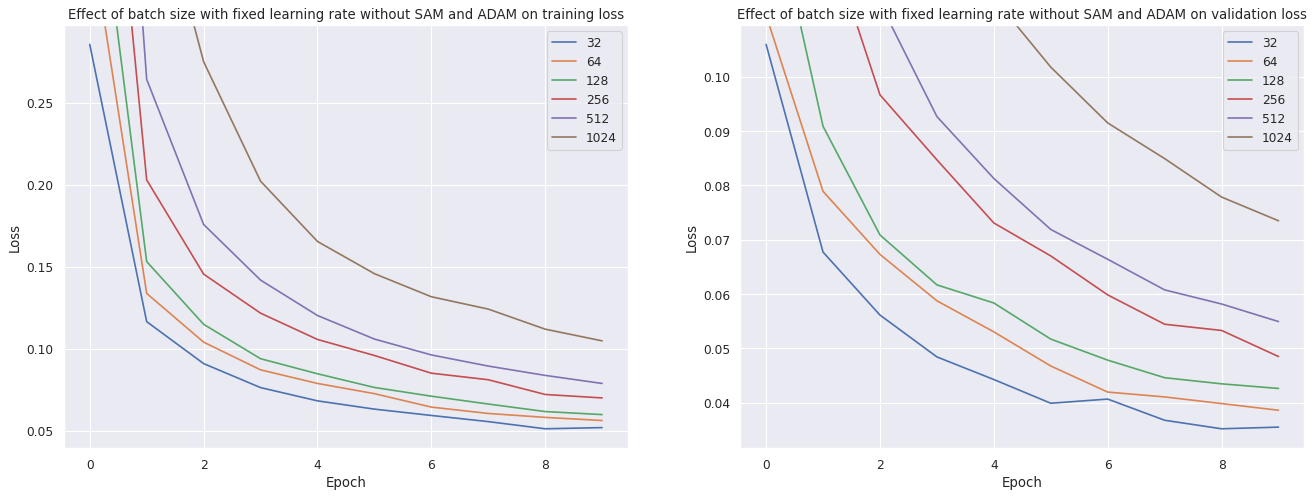

<Figure size 432x288 with 0 Axes>

In [118]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM', 'fixed_lr_diff_bs_ADAM_noSAM')

#### sharpness

In [119]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 14ms/step - loss: 0.0212 - accuracy: 0.9941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12059D-02    |proj g|=  1.42544D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.2285 - accuracy: 0.9232

At iterate    1    f= -2.28544D-01    |proj g|=  2.57166D-02
  ys=-2.673E+01  -gs= 1.138E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9683 - accuracy: 0.6713

At iterate    2    f= -9.68280D-01    |proj g|=  2.96462D-02
  ys=-4.939E+01  -gs= 1.466E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.1302 - accuracy: 0.6327

At iterate    3    f= -1.13023D+00    |proj g|=  3.04544D-02
  ys=-4.322E+00  -gs= 5.099E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.1694 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 1.1804 - accuracy: 0.6185

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      5      7  43343     3 41961   2.584D-02  -1.169D+00
  F =  -1.1694161891937256     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13/47 [=======>......................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9911


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 16ms/step - loss: 0.0269 - accuracy: 0.9921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.68663D-02    |proj g|=  1.54243D-02
47/47 [==============================] - 1s 13ms/step - loss: 0.7695 - accuracy: 0.7652

At iterate    1    f= -7.69480D-01    |proj g|=  2.89742D-02
  ys=-9.717E+01  -gs= 2.349E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 2.8517 - accuracy: 0.4968

At iterate    2    f= -2.85169D+00    |proj g|=  2.89274D-02
  ys=-1.603E+02  -gs= 3.765E+01 BFGS update SKIPPED
47/47 [==============================] - 0s 9ms/step - loss: 3.1385 - accuracy: 0.4628

At iterate    3    f= -3.13848D+00    |proj g|=  2.54723D-02
  ys=-8.816E+00  -gs= 9.449E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 3.1553 - accurac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 3.1685 - accuracy: 0.4692

At iterate    7    f= -3.16851D+00    |proj g|=  2.25711D-02
47/47 [==============================] - 1s 12ms/step - loss: 3.1686 - accuracy: 0.4692

At iterate    8    f= -3.16860D+00    |proj g|=  2.25514D-02
13/47 [=======>......................] - ETA: 0s - loss: 3.1666 - accuracy: 0.4676


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 3.1683 - accuracy: 0.4700

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     12  53232     5 51028   2.255D-02  -3.169D+00
  F =  -3.1686038970947266     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13/47 [=======>......................] - ETA: 0s - loss: 0.0369 - accuracy: 0.9895


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 11ms/step - loss: 0.0315 - accuracy: 0.9914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15297D-02    |proj g|=  1.42887D-02
47/47 [==============================] - 1s 13ms/step - loss: 1.1613 - accuracy: 0.6416

At iterate    1    f= -1.16126D+00    |proj g|=  2.78711D-02
  ys=-1.154E+02  -gs= 3.064E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.4035 - accuracy: 0.3326

At iterate    2    f= -4.40349D+00    |proj g|=  2.82976D-02
  ys=-2.518E+02  -gs= 5.343E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 5.3588 - accuracy: 0.3100

At iterate    3    f= -5.35879D+00    |proj g|=  2.72292D-02
  ys=-2.707E+01  -gs= 3.127E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.5067 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 5.5404 - accuracy: 0.3155

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      6      8  54402     4 50133   2.632D-02  -5.567D+00
  F =  -5.5668892860412598     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13/47 [=======>......................] - ETA: 0s - loss: 0.0424 - accuracy: 0.9874


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 12ms/step - loss: 0.0378 - accuracy: 0.9891
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.78319D-02    |proj g|=  1.46502D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.4272 - accuracy: 0.4357

At iterate    1    f= -2.42720D+00    |proj g|=  2.62566D-02
  ys=-2.562E+02  -gs= 3.080E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.7008 - accuracy: 0.2929

At iterate    2    f= -9.70076D+00    |proj g|=  2.69774D-02
  ys=-4.412E+02  -gs= 1.479E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 10.3296 - accuracy: 0.2930

At iterate    3    f= -1.03296D+01    |proj g|=  2.48014D-02
  ys=-1.418E+01  -gs= 2.231E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 10.3465 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 10.3637 - accuracy: 0.2931

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      5      7  53752     3 51920   2.332D-02  -1.035D+01
  F =  -10.346541404724121     

ABNORMAL_TERMINATION_IN_LNSRCH                              
13/47 [=======>......................] - ETA: 0s - loss: 0.0489 - accuracy: 0.9857


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 11ms/step - loss: 0.0456 - accuracy: 0.9872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.55557D-02    |proj g|=  1.42450D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.0580 - accuracy: 0.5658

At iterate    1    f= -2.05801D+00    |proj g|=  2.49856D-02
  ys=-1.746E+02  -gs= 3.591E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 9.7589 - accuracy: 0.3607

At iterate    2    f= -9.75886D+00    |proj g|=  2.86560D-02
  ys=-5.269E+02  -gs= 1.167E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.9287 - accuracy: 0.3374

At iterate    3    f= -1.09287D+01    |proj g|=  2.53627D-02
  ys=-2.316E+01  -gs= 4.375E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 11.9889 - accu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 14ms/step - loss: 0.0660 - accuracy: 0.9810
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.59509D-02    |proj g|=  1.36898D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.2738 - accuracy: 0.4467

At iterate    1    f= -2.27384D+00    |proj g|=  2.58491D-02
  ys=-1.740E+02  -gs= 4.097E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 13.7722 - accuracy: 0.3289

At iterate    2    f= -1.37722D+01    |proj g|=  2.57447D-02
  ys=-8.482E+02  -gs= 1.869E+02 BFGS update SKIPPED
47/47 [==============================] - 0s 9ms/step - loss: 15.6226 - accuracy: 0.2966

At iterate    3    f= -1.56226D+01    |proj g|=  2.56684D-02
  ys=-6.545E+01  -gs= 4.394E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 16.0165 - accu

In [120]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3004.6832497152504,
 ('fixed', 'sgd', 'sam', 64): 3205.3047990838536,
 ('fixed', 'sgd', 'sam', 128): 3262.596435561185,
 ('fixed', 'sgd', 'sam', 256): 2780.4372946407334,
 ('fixed', 'sgd', 'sam', 512): 2547.4219339386086,
 ('fixed', 'sgd', 'sam', 1024): 2093.451583655359,
 ('fixed', 'sgd', 'asam', 32): 2830.121866418174,
 ('fixed', 'sgd', 'asam', 64): 3335.878978298347,
 ('fixed', 'sgd', 'asam', 128): 3211.113582873208,
 ('fixed', 'sgd', 'asam', 256): 2788.7943896653946,
 ('fixed', 'sgd', 'asam', 512): 2473.5385935256895,
 ('fixed', 'sgd', 'asam', 1024): 2301.159635175606,
 ('increasing', 'sgd', 'sam', 32, 0.001): 1784.6237600877948,
 ('increasing', 'sgd', 'sam', 64, 0.002): 2418.1310305294387,
 ('increasing', 'sgd', 'sam', 128, 0.004): 2483.0266277208334,
 ('increasing', 'sgd', 'sam', 256, 0.008): 3435.485341318249,
 ('increasing', 'sgd', 'sam', 512, 0.016): 3299.348872531065,
 ('increasing', 'sgd', 'sam', 1024, 0.032): 468.834091695867,
 ('fixed', 'adam'

#### Runtime

In [121]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.7792428731918335
	Converged in 8 epochs
	Overall training time (in seconds) until convergence:  45.46837544441223
Batch size:  64
	Mean time per epoch:  2.960205864906311
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  26.83849310874939
Batch size:  128
	Mean time per epoch:  2.1419142484664917
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  19.236512899398804
Batch size:  256
	Mean time per epoch:  1.7603012084960938
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  15.918105363845825
Batch size:  512
	Mean time per epoch:  1.4466853618621827
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  13.106675624847412
Batch size:  1024
	Mean time per epoch:  1.3083014726638793
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  11.890299797058105


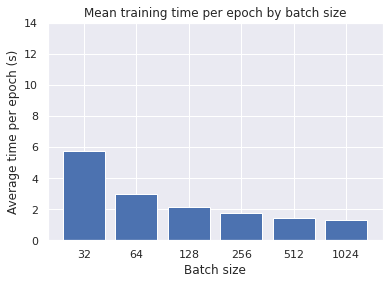

<Figure size 432x288 with 0 Axes>

In [122]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

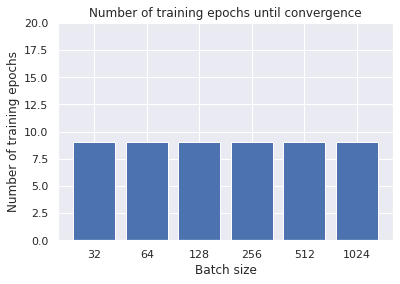

<Figure size 432x288 with 0 Axes>

In [123]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

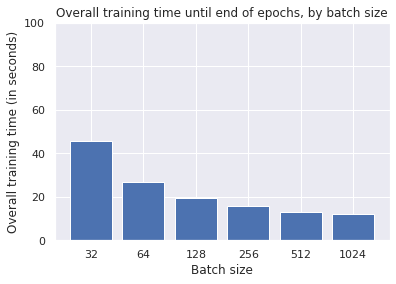

<Figure size 432x288 with 0 Axes>

In [124]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [38]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = 10

key = ('increasing', 'sgd', 'sam')

In [39]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [40]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [41]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [42]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive = True, rho = 2.0)       
        train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))

        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models[key + (batch_size, lr)] = model

Epoch 1/10
1498/1500 [============================>.] - ETA: 0s - loss: 0.7962 - accuracy: 0.7354
Epoch 1: val_loss improved from inf to 0.25471, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7955 - accuracy: 0.7357 - val_loss: 0.2547 - val_accuracy: 0.9312
Epoch 2/10
1494/1500 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9078
Epoch 2: val_loss improved from 0.25471 to 0.15688, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2602 - accuracy: 0.9078 - val_loss: 0.1569 - val_accuracy: 0.9582
Epoch 3/10
1498/1500 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9271
Epoch 3: val_loss improved from 0.15688 to 0.12722, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1982 - accurac

375/375 [==============================] - 3s 8ms/step - loss: 0.1454 - accuracy: 0.9482 - val_loss: 0.1086 - val_accuracy: 0.9699
Epoch 5/10
371/375 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9533
Epoch 5: val_loss improved from 0.10863 to 0.09769, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1285 - accuracy: 0.9533 - val_loss: 0.0977 - val_accuracy: 0.9723
Epoch 6/10
373/375 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9571
Epoch 6: val_loss improved from 0.09769 to 0.08987, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.1172 - accuracy: 0.9571 - val_loss: 0.0899 - val_accuracy: 0.9751
Epoch 7/10
373/375 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9603
Epoch 7: val_loss improved from 0.08987 to 0.08390, saving model to tmp/mod

93/94 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9663
Epoch 8: val_loss improved from 0.08205 to 0.07663, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.0934 - accuracy: 0.9663 - val_loss: 0.0766 - val_accuracy: 0.9774
Epoch 9/10
94/94 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9686
Epoch 9: val_loss improved from 0.07663 to 0.07262, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.0874 - accuracy: 0.9686 - val_loss: 0.0726 - val_accuracy: 0.9786
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9705
Epoch 10: val_loss improved from 0.07262 to 0.06928, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0823 - accuracy: 0.9703 - val_loss: 0

In [43]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], diff_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(diff_lr_state_filename)

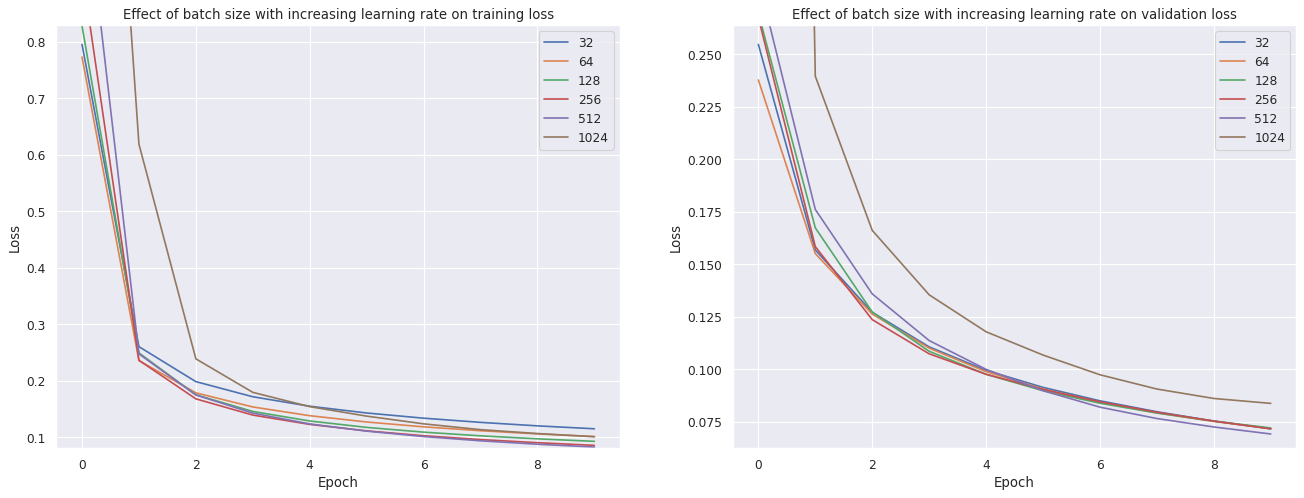

<Figure size 432x288 with 0 Axes>

In [44]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### sharpness

In [46]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

47/47 [==============================] - 1s 13ms/step - loss: 0.0641 - accuracy: 0.9830
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.41121D-02    |proj g|=  1.51620D-02
47/47 [==============================] - 1s 10ms/step - loss: 1.3417 - accuracy: 0.5633

At iterate    1    f= -1.34175D+00    |proj g|=  3.03240D-02
  ys=-8.783E+01  -gs= 4.469E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 7.0147 - accuracy: 0.4649

At iterate    2    f= -7.01466D+00    |proj g|=  2.86295D-02
  ys=-4.562E+02  -gs= 7.140E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.7393 - accuracy: 0.3829

At iterate    3    f= -1.27393D+01    |proj g|=  2.35289D-02
  ys=-3.755E+02  -gs= 9.065E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 15.2115 - accu

47/47 [==============================] - 1s 12ms/step - loss: 26.4260 - accuracy: 0.2864

At iterate   10    f= -2.64260D+01    |proj g|=  2.16557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     11  58946     9 53594   2.166D-02  -2.643D+01
  F =  -26.425966262817383     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 13ms/step - loss: 0.0608 - accuracy: 0.9829
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 35.0083 - accuracy: 0.1021

At iterate    7    f= -3.50083D+01    |proj g|=  2.01068D-02
  ys=-1.504E-02  -gs= 3.801E-02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 35.0085 - accuracy: 0.1021

At iterate    8    f= -3.50085D+01    |proj g|=  2.21572D-02
  ys=-7.103E-03  -gs= 5.868E-03 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 35.0087 - accuracy: 0.1021

At iterate    9    f= -3.50087D+01    |proj g|=  2.19044D-02
  ys=-6.556E-03  -gs= 6.787E-03 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 35.0091 - accuracy: 0.1021

At iterate   10    f= -3.50091D+01    |proj g|=  2.20385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fi

In [47]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3004.6832497152504,
 ('fixed', 'sgd', 'sam', 64): 3205.3047990838536,
 ('fixed', 'sgd', 'sam', 128): 3262.596435561185,
 ('fixed', 'sgd', 'sam', 256): 2780.4372946407334,
 ('fixed', 'sgd', 'sam', 512): 2547.4219339386086,
 ('fixed', 'sgd', 'sam', 1024): 2093.451583655359,
 ('fixed', 'sgd', 'asam', 32): 2830.121866418174,
 ('fixed', 'sgd', 'asam', 64): 3335.878978298347,
 ('fixed', 'sgd', 'asam', 128): 3211.113582873208,
 ('fixed', 'sgd', 'asam', 256): 2788.7943896653946,
 ('fixed', 'sgd', 'asam', 512): 2473.5385935256895,
 ('fixed', 'sgd', 'asam', 1024): 2301.159635175606,
 ('increasing', 'sgd', 'sam', 32, 0.001): 1784.6237600877948,
 ('increasing', 'sgd', 'sam', 64, 0.002): 2418.1310305294387,
 ('increasing', 'sgd', 'sam', 128, 0.004): 2483.0266277208334,
 ('increasing', 'sgd', 'sam', 256, 0.008): 3435.485341318249,
 ('increasing', 'sgd', 'sam', 512, 0.016): 3299.348872531065,
 ('increasing', 'sgd', 'sam', 1024, 0.032): 468.834091695867}

In [48]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  8.096037673950196
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  70.16709423065186
Batch size:  64
	Mean time per epoch:  4.054022789001465
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  36.947020292282104
Batch size:  128
	Mean time per epoch:  3.132106351852417
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  28.234553575515747
Batch size:  256
	Mean time per epoch:  2.598355841636658
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  23.52250385284424
Batch size:  512
	Mean time per epoch:  2.3375290632247925
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.02222204208374
Batch size:  1024
	Mean time per epoch:  2.21843683719635
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  20.099091291427612


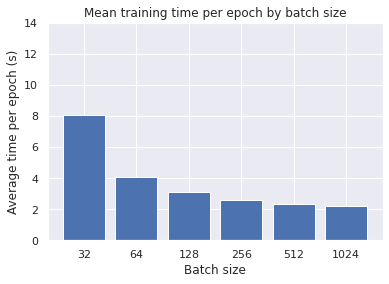

<Figure size 432x288 with 0 Axes>

In [49]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

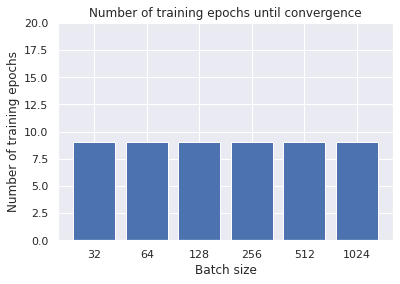

<Figure size 432x288 with 0 Axes>

In [50]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

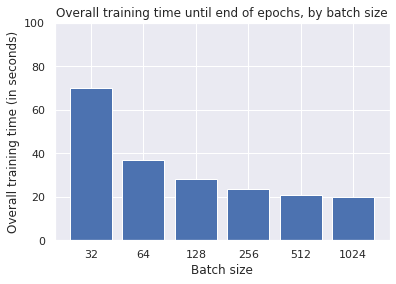

<Figure size 432x288 with 0 Axes>

In [51]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)